**NOTEBOOK NEURAL NETWORK EXAM** 
---

<font size="5">Title: <span style="color:red">**C**</span>ontinuous <span style="color:red">**k**</span>ernel <span style="color:red">**T**</span>emporal-aware b<span style="color:red">**I**</span>-direction <span style="color:red">**M**</span>ulti-scale <span style="color:red">**net**</span>work (CkTIM-net) for **Speech Emotion Recognition** (SER)</font>

Authors: **Massimo Romano** (2043836), **Paolo Renzi** (1887793)

<img src="./images/image_1.jpg" alt="Description" width="300" height = "300" />

<font size="5">Introduction</font>

<font size="3"> **Speech Emotion Recognition** (SER) is the task that consists in automatically recognise the human emotion by voice signal. Technically speaking it's a **multi-class classification task**. This task plays a fundamental role in Machine Learning because of the growing importance of **HRI (Human Robot Interaction)**, in which we want algorithm that permits to the robot to recognise emotions and **improving communication with humans**.
Traditional methods (before Deep Learning) tried to apply hand-crafted methods to extract significant features from speech signals, while Deep Learning methods tried to learn the class-discriminative features in an end-to-end manner, using various architectures such as Convolutional Neural Network (CNN), Recurrent Neural Network (RNN) or the combination of CNN and RNN. 
</font>

<font size="5">TIM-net</font>

**TIM-net** is a novel temporal emotional modeling approach to learn multi-scale contextual affective representations from various time scale with 3 main contributions: 
- a temporal-aware block based on the Dilated Causal Convolution (DC Conv) as a core unit in TIM-Net. 
The dilated convolution can enlarge and refine the receptive field of temporal patterns by padding the kernel and making it see samples further away at the cost of some closer by. The causal convolution combined with dilated convolution can help model relax the
assumption of first-order Markov property compared with
RNNs. In this way, they can incorporate an 𝑁-order (𝑁
denotes the number of all previous frames) connection into
the network to aggregate information from different temporal
locations.
- a novel bi-direction architecture integrating complementary information from the past and the future for modeling long-range temporal dependencies. To the best of our knowledge, TIM-Net is the first bi-direction temporal network by focusing on multi-scale fusion in the SER, rather than simply concatenating forward and backward hidden states. 
- a dynamic fusion module by combining dynamic receptive fields for learning the inter-
dependencies at different temporal scales, so as to improve
the model generalizability. Due to the articulation speed and
pause time varying significantly across speakers, the speech
requires different efficient receptive fields (i.e., the time scale
that reflects the affective characteristics) for each low-level
feature (e.g., MFCC).


<img src="./images/TIM-net.png" alt="Description" width="700" height = "300" />


<font size="5">Proposed Method</font>

<font size="3"> </font>







<font size='5'>HOW TO USE THIS NOTEBOOK:</font>

1) Change 'config.yaml' file:

To initialize the model hyperparameters and the training hyperparameters you SHOULD change the config.yaml file in '/conf/config.yaml' directory

In particular you can set:

- train:

  - num_epochs
  
  - batch_size

  - learning_rate

  - optimizer
  
  - early_stopping

  - patience

  - lr_scheduler
  
  - label_smoothing

- model:

  - dropout_rate

  - n_temporal_aware_block

  - n_filter

  - num_features

  - ck

  - generator_type

  - kernel_size

  - omega_0

  - hidden_scale

  - af_type

  - aug

 2) Run:

  You can run all the notebook to do the training both in 'local' and in 'colab', the code automatically recognise it.

  If you are in 'local' the code automatically recognise what type of device you are using. The supported device are:
  
  - 'cuda': Nvidia GPUs

  - 'mps': Apple Silicon GPUs (M1, M2 ...)

  - 'cpu': No GPUs

The result are:

1) Download the dataset, Split it, Augment it

2) Train the model in the configuration chosen by 'config.yaml' file and generate a directory in ./training/results' with:
  
  -  'model.pt' file: weights of the model trained (to use in notebook_test.ipynb for testing)

  -  'training_metrics.json': save the metrics (loss, accuracy, precision...) in training set

  -  'validation_metrics.json': save the metrics (loss, accuracy, precision...) in validation set

  -  'parameters.txt': save the configuration of the 'config.yaml' file

⚠️Clone the repository to use all the functions needed by the main code⚠️
---





In [1]:
try:
    import google.colab
    mode = 'colab'
except:
    mode = 'local'

if mode == 'colab':
    !git clone "https://github.com/cybernetic-m/nn-project.git"
    !pip install hydra-core --upgrade convkan
else:
    print("You are running locally!")

You are running locally!


# IMPORT AND INITIALIZATION

In [2]:
# Import for config.yaml file
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import random

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from torch.optim.lr_scheduler import ReduceLROnPlateau

if mode == 'colab':
    sys.path.append('/content/nn-project/dataloader')
    sys.path.append('/content/nn-project/model')
    sys.path.append('/content/nn-project/module')
    sys.path.append('/content/nn-project/training')
    sys.path.append('/content/nn-project/testing')
    from preprocessing import Preprocessing
    import utils
    import dataset
    from ctim import CTIM
    from train import *
    from test import *


if mode == 'local':
    import dataloader.utils as utils
    import dataloader.dataset as dataset
    from dataloader.preprocessing import Preprocessing
    from model.ctim import CTIM
    from training.train import train as train
    from testing.test import test as test


Reproducibility

This set a random seed to ensure that all the trials will be reproducible in the same way other times, obtaining same results in different runs.

In [3]:
# Set the seed
seed = 46

# Set seed for torch, numpy and random libraries
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

# Set the devide mode on GPU (if available CUDA for Nvidia and  MPS for Apple Silicon) or CPU
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"


## Download and Split Dataset

EMOVO is a dataset composed of 588 samples of recordings of stereo audio sampled at 48khz and saved in wav format.
Each sample is a phrase pronounced by 6 actors (3 males and 3 females) with ids as m1-3 and f1-3.

Each phrase has an id based on:
- b1, b2, b3 brevi short
- l1, l2, l3, l4 lunghe long
- n1, n2, n3, n4, n5 nonsense
- d1, d2 domande (questions)

and each emotion is identified like this:
- *neu*tro neutral
- *dis*gusto disgust
- *gio*ia joy
- *pau*ra fear
- *rab*bia anger
- *sor*presa surprise
- *tri*stezza sadness

Each file then is identified like this emotionid-actorid-phraseid.wav

More information about the dataset is available on "./papers/emovo.pdf"

To split the dataset we first put samples with the same class in the same directory, Then we counted how many samples we had in each class and multiplied it by the percentage of samples we wanted in that split. We then created a list of indexes of that length to get the file with those indexes from the folders of each class to have a balanced random selection of files.

For the split we have chosen:

- 70 % of samples for Training set
- 20 % of samples for Test set
- 10 % of sample for Validation set


In [4]:
link_dataset = "https://drive.google.com/file/d/1nzKBta2M3khw7Ql_S7atYg-H-bWDiOxr/view?usp=drive_link"
gdrive_link = "https://drive.google.com/uc?export=download&id="

if mode == 'colab':
    destination_dir = "/content/emovo.zip"
    extract_dir = '/content/dataset'
    emovo_dir = '/content/dataset/EMOVO'
    emovo_split_dir = '/content/dataset/EMOVO_split'
elif mode == 'local':
    destination_dir = "./emovo.zip"
    extract_dir = "./dataset"
    emovo_dir = "./dataset/EMOVO"
    emovo_split_dir = './dataset/EMOVO_split'

utils.download_dataset(link_dataset, destination_dir, gdrive_link, extract_dir)

utils.dataset_split(emovo_dir, extract_dir, 0.7, 0.2, 0.1)


Dataset already downloaded
Dataset already unzipped


# Split the MFCC dataset

We manged to find also the dataset already processed by the authors of TIM-net and we split it following a similar idea to how we splitted the original dataset

In [5]:
if mode == 'colab':
    utils.dataset_split_mfcc('./nn-project/EMOVO.npy', extract_dir, 0.7, 0.2, 0.1)
elif mode == 'local':
    utils.dataset_split_mfcc('./EMOVO.npy', extract_dir, 0.7, 0.2, 0.1)

MFCC features already exists!


# Data Augmentation

To augment the data we selected 4 transformations and applied all of them to each sample to augment the dataset as much as possible. The selected transformations where:

- White Noise adding
- Shifting the signal either to left or right randomly, by padding one side and cutting the other
- Speeding up a track and changing the pitch of a random amount 
- Reversing the track

In [6]:
preprocessing = Preprocessing(device=device)

utils.augment_data(emovo_split_dir, extract_dir, preprocessing, device)

The augmented dataset already exist!


## Dataset Exploration

In this part we'll see the original dataset, the augmented dataset and different examples of audio

In [7]:
train_path = os.path.join(extract_dir, 'EMOVO_split', 'train')
test_path = os.path.join(extract_dir, 'EMOVO_split', 'test')
val_path = os.path.join(extract_dir, 'EMOVO_split', 'val')

train_dataset = dataset.EMOVO_Dataset(train_path, feature_extract=False, mfcc_np=False, device=device)
test_dataset = dataset.EMOVO_Dataset(test_path, feature_extract=False, mfcc_np=False, device=device)
val_dataset = dataset.EMOVO_Dataset(val_path, feature_extract=False, mfcc_np=False, device=device)

train_aug_path = os.path.join(extract_dir, 'EMOVO_aug', 'train')
test_aug_path = os.path.join(extract_dir, 'EMOVO_aug', 'test')
val_aug_path = os.path.join(extract_dir, 'EMOVO_aug', 'val')

train_aug_dataset = dataset.EMOVO_Dataset(train_aug_path, feature_extract=False, mfcc_np=False, device=device)
test_aug_dataset = dataset.EMOVO_Dataset(test_aug_path,feature_extract=False, mfcc_np=False, device=device)
val_aug_dataset = dataset.EMOVO_Dataset(val_aug_path, feature_extract=False, mfcc_np=False, device=device)

fixed a mono track: rab-f1-b1.wav


<font size='5'>**Example of audio in original dataset**</font>

Tensor of shape: torch.Size([2, 251904]) Sample Rate: 48000
Class: tri 



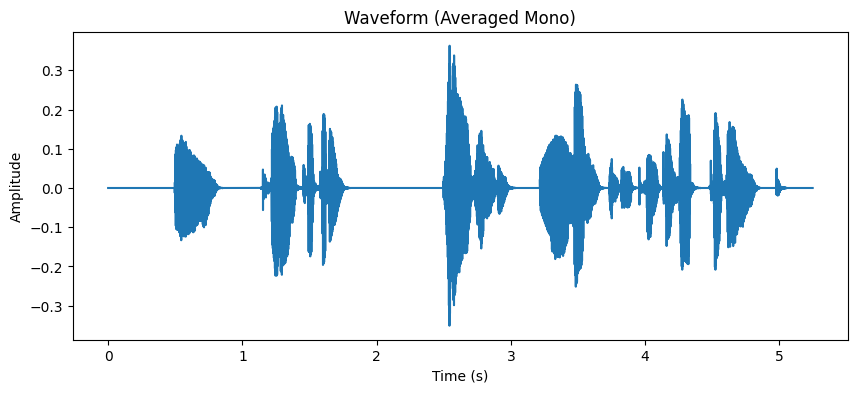

In [8]:
classes = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']
random_num = random.randint(1, train_dataset.__len__())
data, label = train_dataset[random_num]

print("Tensor of shape:",data[0].shape, "Sample Rate:", data[1])
print("Class:", classes[label], "\n")

# Waveform
# Compute the average of both channels to get a mono waveform
mono_waveform = data[0].mean(dim=0)
num_samples = mono_waveform.shape[0]
sample_rate = data[1]
time_axis = np.linspace(0, num_samples / sample_rate, num_samples)

# Play the audio
display(Audio(mono_waveform.cpu().numpy(), rate=sample_rate))

# Plot the averaged (mono) waveform
plt.figure(figsize=(10, 4))
plt.plot(time_axis, mono_waveform.cpu().numpy())
plt.title('Waveform (Averaged Mono)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()



<font size='5'>**Example of audio in augmented dataset**</font>

Tensor of shape: torch.Size([2, 146432]) Sample Rate: 48000
Class: dis 



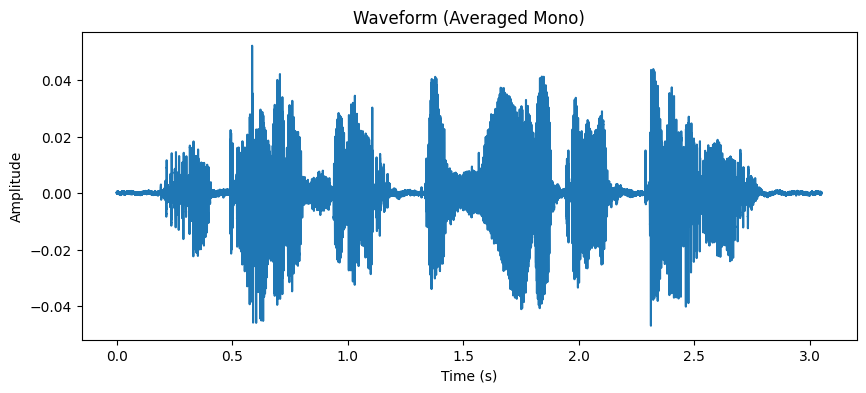

In [9]:
classes = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']
random_num = random.randint(1, train_dataset.__len__())
data, label = train_aug_dataset[random_num]

print("Tensor of shape:",data[0].shape, "Sample Rate:", data[1])
print("Class:", classes[label], "\n")

# Waveform
# Compute the average of both channels to get a mono waveform
mono_waveform = data[0].mean(dim=0)
num_samples = mono_waveform.shape[0]
sample_rate = data[1]
time_axis = np.linspace(0, num_samples / sample_rate, num_samples)

# Play the audio
display(Audio(mono_waveform.cpu().numpy(), rate=sample_rate))

# Plot the averaged (mono) waveform
plt.figure(figsize=(10, 4))
plt.plot(time_axis, mono_waveform.cpu().numpy())
plt.title('Waveform (Averaged Mono)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

<font size='5'>**Data distribution (original)**</font>

In this part we can see the original dataset distribution after the split in training, validation and test set.

- 58 samples x 7 classes = 406 samples (Training)

- 10 samples x 7 classes = 70 samples (Validation)

- 16 samples x 7 classes =  112 samples (Test)

                         558 samples (TOT)

                            


[58, 58, 58, 58, 58, 58, 58]


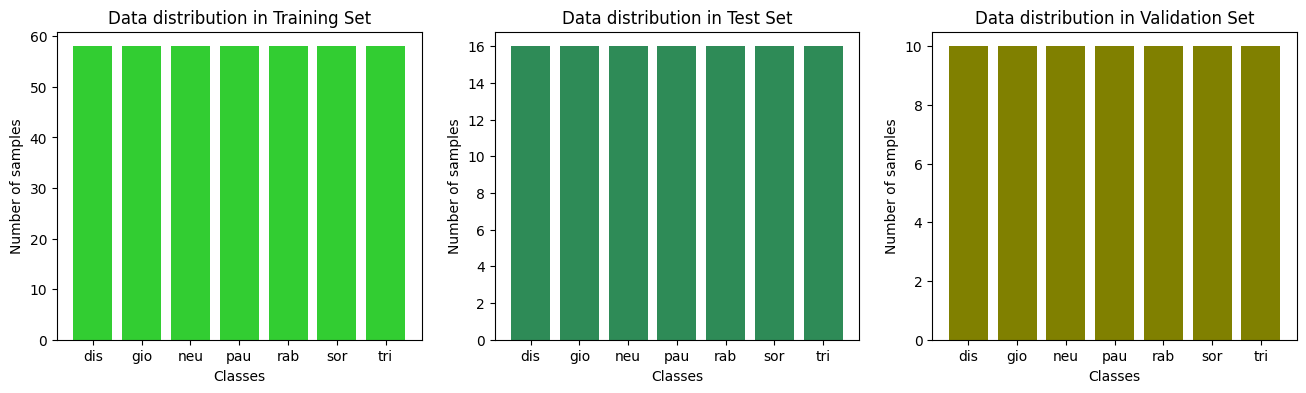

In [15]:
train_counts = train_dataset.get_info()
test_counts = test_dataset.get_info()
val_counts = val_dataset.get_info()
classes = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']

fig, ax = plt.subplots(1,3, figsize=(16, 4))

ax[0].bar(classes, train_counts, color='limegreen')
ax[0].set_title("Data distribution in Training Set")
ax[0].set_xlabel("Classes")
ax[0].set_xticks(ticks=range(7), labels=classes)
ax[0].set_ylabel("Number of samples")

ax[1].bar(classes, test_counts, color='seagreen')
ax[1].set_title("Data distribution in Test Set")
ax[1].set_xlabel("Classes")
ax[1].set_xticks(ticks=range(7), labels=classes)
ax[1].set_ylabel("Number of samples")

ax[2].bar(classes, val_counts, color='olive')
ax[2].set_title("Data distribution in Validation Set")
ax[2].set_xlabel("Classes")
ax[2].set_xticks(ticks=range(7), labels=classes)
ax[2].set_ylabel("Number of samples")
plt.show()

<font size='5'>**Data distribution (after augmentation)**</font>

We have applied 4 different transformations (described in augmentation section of this notebook) to each sample of Training Set. 

The result distribution is:

- [58 samples + (58 samples x 4 transformations)] x 7 classes = 2030 samples (Training)

- 10 samples x 7 classes = 70 samples (Validation)

- 16 samples x 7 classes =  112 samples (Test)

                         2212 samples (TOT)

[290, 290, 290, 290, 290, 290, 290]


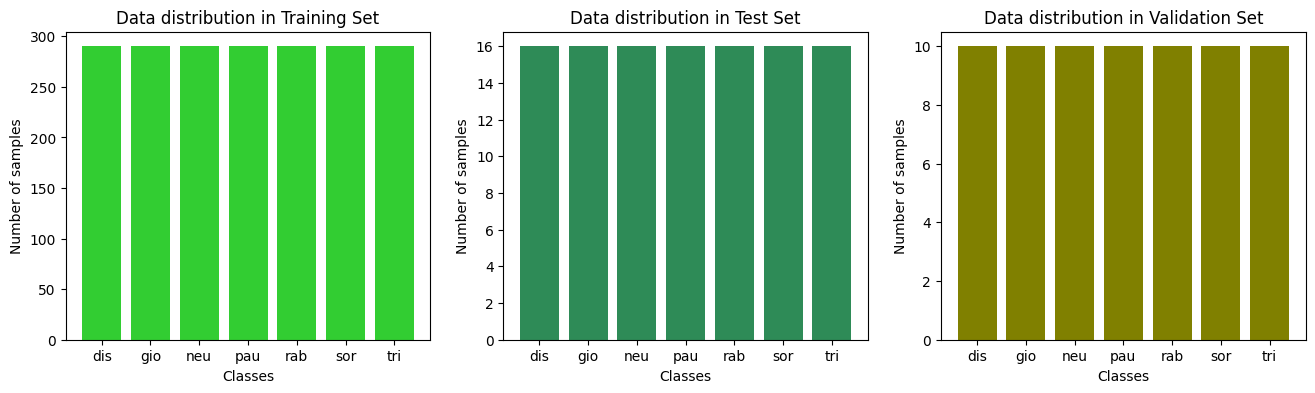

In [16]:
train_aug_counts = train_aug_dataset.get_info()
test_aug_counts = test_aug_dataset.get_info()
val_aug_counts = val_aug_dataset.get_info()
classes = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']

fig, ax = plt.subplots(1,3, figsize=(16, 4))

ax[0].bar(classes, train_aug_counts, color='limegreen')
ax[0].set_title("Data distribution in Training Set")
ax[0].set_xlabel("Classes")
ax[0].set_xticks(ticks=range(7), labels=classes)
ax[0].set_ylabel("Number of samples")

ax[1].bar(classes, test_aug_counts, color='seagreen')
ax[1].set_title("Data distribution in Test Set")
ax[1].set_xlabel("Classes")
ax[1].set_xticks(ticks=range(7), labels=classes)
ax[1].set_ylabel("Number of samples")

ax[2].bar(classes, val_aug_counts, color='olive')
ax[2].set_title("Data distribution in Validation Set")
ax[2].set_xlabel("Classes")
ax[2].set_xticks(ticks=range(7), labels=classes)
ax[2].set_ylabel("Number of samples")
plt.show()

# MODEL INITIALIZATION

To initialize the model we have used Hydra with a "config.yaml" ('./conf/config.yaml') file in which we have defined all the hyperparameters (batch_size, learning_rate ...) both for the model and training.

You SHOULD change the parameters before training!

In [12]:
# Check if Hydra is initialized
if GlobalHydra().is_initialized():
    # Clear the Hydra instance if it is initialized
    GlobalHydra.instance().clear()
    print("Hydra instance was initialized and has been cleared.")
else:
    # Initialize
    print("Hydra now initialized!")

# Initialization and Load configuration
if mode == 'local':
  initialize(config_path="./conf", job_name="notebook_nn_exam", version_base=None)
  cfg = compose(config_name="config")

elif mode == 'colab':
  initialize(config_path="./nn-project/conf", job_name="notebook_nn_exam", version_base=None)
  cfg = compose(config_name="config")


Hydra now initialized!


In [13]:
# Load the hyperparameters of the model
DROPOUT_RATE = cfg.model.dropout_rate
KERNEL_SIZE = cfg.model.kernel_size
N_TAB = cfg.model.n_temporal_aware_block
N_FILTER = cfg.model.n_filter
NUM_FEATURES = cfg.model.num_features
CK = cfg.model.ck
GEN_TYPE = cfg.model.generator_type
OMEGA_0 = cfg.model.omega_0
AF_TYPE = cfg.model.af_type
AUG = cfg.model.aug
HIDDEN_SCALE = cfg.model.hidden_scale


model = CTIM(
    kernel_size=KERNEL_SIZE,
    dropout_rate=DROPOUT_RATE,
    n_temporal_aware_block=N_TAB,
    n_filter=N_FILTER,
    in_channels=39,
    ck=CK,
    num_features=NUM_FEATURES,
    num_classes = 7,
    generator_type= GEN_TYPE,
    omega_0=OMEGA_0,
    af_type=AF_TYPE,
    hidden_scale=HIDDEN_SCALE,
    device=device
)

# TRAINING

In [14]:
# Load the hyperparameters for training
EPOCHS = cfg.train.num_epochs
BATCH_SIZE = cfg.train.batch_size
LEARNING_RATE = cfg.train.learning_rate
OPTI = cfg.train.optimizer
EARLY_STOPPING = cfg.train.early_stopping
PATIENCE = cfg.train.patience
LR_SCHEDULER = cfg.train.lr_scheduler
LABEL_SMOOTHING = cfg.train.label_smoothing

# Initialization of the metrics' dictionary
training_metrics_dict = {
    "model" : [model.model_name],
    "epoch": [],
    "loss": [],
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1_score": [],
}
validation_metrics_dict = {
    "model" : [model.model_name],
    "epoch": [],
    "loss": [],
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1_score": [],
}

if AUG == True:
    # Dataloader initialization for training, validation and test
    train_path = os.path.join(extract_dir, 'EMOVO_aug', 'train')
    val_path = os.path.join(extract_dir, 'EMOVO_aug', 'val')

    train_dataset = dataset.EMOVO_Dataset(train_path, feature_extract=True, mfcc_np=False, device=device)
    val_dataset = dataset.EMOVO_Dataset(val_path, feature_extract=True, mfcc_np=False, device=device)

elif AUG == False:

    train_path = os.path.join(extract_dir, 'EMOVO_split_MFCC', 'train')
    val_path = os.path.join(extract_dir, 'EMOVO_split_MFCC', 'val')

    train_dataset = dataset.EMOVO_Dataset(train_path, feature_extract=False, mfcc_np=True, device=device)
    val_dataset = dataset.EMOVO_Dataset(val_path, feature_extract=False, mfcc_np=True, device=device)


# Dataloader initialization
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Definition of the Categorical Cross Entropy Loss
loss_fn = nn.CrossEntropyLoss(label_smoothing = LABEL_SMOOTHING)

# Definition of the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=LR_SCHEDULER, patience=5)

train(
    EPOCHS, 
    training_metrics_dict, 
    validation_metrics_dict, 
    train_dataloader, 
    val_dataloader, 
    model, 
    loss_fn, 
    optimizer, 
    lr_scheduler, 
    cfg
)

KeyboardInterrupt: 

References
---
[1] [TEMPORAL MODELING MATTERS: A NOVEL TEMPORAL EMOTIONAL MODELING
APPROACH FOR SPEECH EMOTION RECOGNITION](https://arxiv.org/pdf/2211.08233)

[2] [CKCONV: CONTINUOUS KERNEL CONVOLUTION FOR
SEQUENTIAL DATA](https://arxiv.org/pdf/2102.02611)